Epoch 1/5, Loss: 18.8738, Train Acc: 0.6737, Val Acc: 0.7379
Epoch 2/5, Loss: 16.0378, Train Acc: 0.7616, Val Acc: 0.7056
Epoch 3/5, Loss: 15.4587, Train Acc: 0.7778, Val Acc: 0.7944
Epoch 4/5, Loss: 13.7770, Train Acc: 0.7990, Val Acc: 0.8105
Epoch 5/5, Loss: 12.7494, Train Acc: 0.8091, Val Acc: 0.7903

✅ Accuracy on CLEAN validation data: 0.7903
❌ Accuracy on NOISY (attacked) data: 0.7540


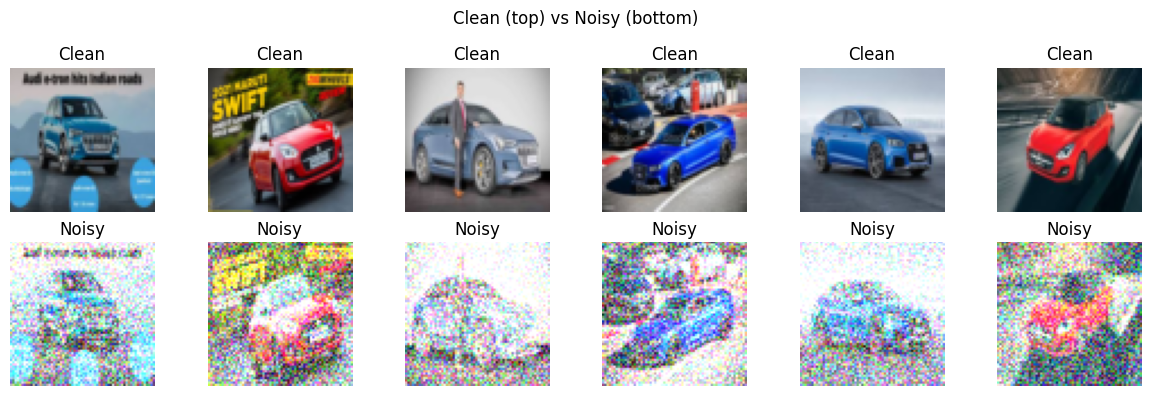

In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random

# === Налаштування ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
CLASSES = ['Audi', 'Swift']

# === Трансформації ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Кастомний датасет з фільтрацією класів ===
class FilteredDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [s for s in self.samples if self.classes[s[1]] in CLASSES]
        self.targets = [s[1] for s in self.samples]
        self.class_to_idx = {cls: i for i, cls in enumerate(CLASSES)}
        self.samples = [(s[0], self.class_to_idx[self.classes[s[1]]]) for s in self.samples]

# === Завантаження ===
dataset = FilteredDataset("/content/drive/MyDrive/Cars Dataset/train", transform=transform)

# === Трен/Вал розбиття ===
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# === CNN модель ===
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 16x32x32
        x = self.pool(F.relu(self.conv2(x)))  # -> 32x16x16
        x = x.view(-1, 32 * (IMG_SIZE // 4) * (IMG_SIZE // 4))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# === Функція оцінки ===
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

# === Тренування ===
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(dim=1) == y).sum().item()
    train_acc = correct / len(train_loader.dataset)
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# === Генерація шуму для атаки ===
def add_ood_noise(images, intensity=0.5):
    noise = torch.rand_like(images) * intensity
    noisy_images = torch.clamp(images + noise, 0, 1)
    return noisy_images

# === Атака на валідаційні дані ===
model.eval()
correct_clean, correct_noisy = 0, 0
sample_imgs = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x_noisy = add_ood_noise(x, intensity=0.7)

        out_clean = model(x)
        out_noisy = model(x_noisy)

        correct_clean += (out_clean.argmax(dim=1) == y).sum().item()
        correct_noisy += (out_noisy.argmax(dim=1) == y).sum().item()

        if len(sample_imgs) == 0:  # тільки для візуалізації
            sample_imgs.append((x.cpu(), x_noisy.cpu(), y.cpu()))


clean_acc = correct_clean / len(val_dataset)
noisy_acc = correct_noisy / len(val_dataset)

print(f"\n✅ Accuracy on CLEAN validation data: {clean_acc:.4f}")
print(f"❌ Accuracy on NOISY (attacked) data: {noisy_acc:.4f}")

# === Візуалізація прикладів ===
def show_attack_examples(batch):
    clean, noisy, labels = batch
    fig, axs = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axs[0, i].imshow(np.transpose(clean[i], (1, 2, 0)))
        axs[0, i].set_title("Clean")
        axs[0, i].axis("off")
        axs[1, i].imshow(np.transpose(noisy[i], (1, 2, 0)))
        axs[1, i].set_title("Noisy")
        axs[1, i].axis("off")
    plt.suptitle("Clean (top) vs Noisy (bottom)")
    plt.tight_layout()
    plt.show()

show_attack_examples(sample_imgs[0])


In [25]:
import copy

def perturb_model_weights_copy(model, loader, epsilon=1e-2):
    # Створити копію моделі
    perturbed_model = copy.deepcopy(model)
    perturbed_model.eval()

    # Градієнт лише на копії
    for param in perturbed_model.parameters():
        if param.requires_grad:
            param.grad = None

    x, y = next(iter(loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    x.requires_grad = True

    output = perturbed_model(x)
    loss = criterion(output, y)
    loss.backward()

    with torch.no_grad():
        for param in perturbed_model.parameters():
            if param.grad is not None:
                param.add_(epsilon * torch.sign(param.grad))

    print(f"\n⚠️ Perturbed copy created with ε={epsilon}")
    return perturbed_model


In [26]:
# === Валідація до атаки (оригінальна модель)
val_acc_before = evaluate(model, val_loader)
print(f"\n✅ Accuracy on validation data BEFORE attack: {val_acc_before:.4f}")

# === Створення атакованої копії моделі
model_attacked = perturb_model_weights_copy(model, train_loader, epsilon=1e-2)

# === Валідація після атаки на копії
val_acc_after = evaluate(model_attacked, val_loader)
print(f"❌ Accuracy on validation data AFTER attack (copy): {val_acc_after:.4f}")



✅ Accuracy on validation data BEFORE attack: 0.7903

⚠️ Perturbed copy created with ε=0.01
❌ Accuracy on validation data AFTER attack (copy): 0.6734
